## Import needed library

In [69]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
import pickle


## Load all data sets

In [70]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")
tags = pd.read_csv("tags.csv")
links = pd.read_csv("links.csv")

In [71]:
print(movies.isnull().sum())
print(ratings.isnull().sum())
print(tags.isnull().sum())
print(links.isnull().sum())

movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64
movieId    0
imdbId     0
tmdbId     8
dtype: int64


### count number of rating and marg that with movies by movie ID

In [72]:
rating_count = ratings.groupby("movieId")["rating"].count().reset_index()
rating_count.columns = ["movieId", "number_of_rating"]
marg_number_of_reting = pd.merge(movies, rating_count, on="movieId")
marg_number_of_reting.head()

,movieId,title,genres,number_of_rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215
1,2,Jumanji (1995),Adventure|Children|Fantasy,110
2,3,Grumpier Old Men (1995),Comedy|Romance,52
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,7
4,5,Father of the Bride Part II (1995),Comedy,49


### Sort the rating and print top 10 rated movies

In [73]:
sort_rating = marg_number_of_reting.sort_values("number_of_rating", ascending=False)
sort_rating.head(10).reset_index()


,index,movieId,title,genres,number_of_rating
0,314,356,Forrest Gump (1994),Comedy|Drama|Romance|War,329
1,277,318,"Shawshank Redemption, The (1994)",Crime|Drama,317
2,257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,307
3,510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,279
4,1938,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,278
5,224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,251
6,418,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,238
7,97,110,Braveheart (1995),Action|Drama|War,237
8,507,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,224
9,461,527,Schindler's List (1993),Drama|War,220


## Average rating for all movies

In [74]:
avg_rating = ratings.groupby("movieId")["rating"].mean()
avg_rating.head()


movieId
1    3.920930
2    3.431818
3    3.259615
4    2.357143
5    3.071429
Name: rating, dtype: float64

## Selecting Movies with at Least 50 Ratings

In [75]:
rating_count = ratings.groupby("movieId")["rating"].count()
valid_movies = rating_count[rating_count >= 50].index


### Sort valid movies and Show top 10 movie

In [76]:
top_rated = avg_rating.loc[valid_movies].sort_values(ascending=False).head(10)

top_rated_df = top_rated.to_frame().merge(movies, on="movieId", how="left")
top_rated_df


,movieId,rating,title,genres
0,318,4.429022,"Shawshank Redemption, The (1994)",Crime|Drama
1,858,4.289062,"Godfather, The (1972)",Crime|Drama
2,2959,4.272936,Fight Club (1999),Action|Crime|Drama|Thriller
3,1276,4.271930,Cool Hand Luke (1967),Drama
4,750,4.268041,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
5,904,4.261905,Rear Window (1954),Mystery|Thriller
6,1221,4.259690,"Godfather: Part II, The (1974)",Crime|Drama
7,48516,4.252336,"Departed, The (2006)",Crime|Drama|Thriller
8,1213,4.250000,Goodfellas (1990),Crime|Drama
9,912,4.240000,Casablanca (1942),Drama|Romance


### Extract years form movie title

In [77]:
movies['year'] = movies['title'].str.extract(r"\((\d{4})\)")
movies['title'] = movies['title'].str.replace(r"\(\d{4}\)", "", regex=True).str.strip()

### Create a string by combining all the tags of each movie.

In [78]:
tags_grouped = tags.groupby("movieId")["tag"].apply(lambda x: " ".join(x)).reset_index()

movies_tags = movies.merge(tags_grouped, on="movieId", how="left")


Combine Genres and Tag

In [94]:
movies_tags["content"] = (
    movies_tags["genres"].fillna("") + " " +
    movies_tags["tag"].fillna("")
)
movies_tags.head()

,movieId,title,genres,year,tag,content
0,1,toy story,Adventure|Animation|Children|Comedy|Fantasy,1995,pixar pixar fun,Adventure|Animation|Children|Comedy|Fantasy pi...
1,2,jumanji,Adventure|Children|Fantasy,1995,fantasy magic board game Robin Williams game,Adventure|Children|Fantasy fantasy magic board...
2,3,grumpier old men,Comedy|Romance,1995,moldy old,Comedy|Romance moldy old
3,4,waiting to exhale,Comedy|Drama|Romance,1995,NaN,Comedy|Drama|Romance
4,5,father of the bride part ii,Comedy,1995,pregnancy remake,Comedy pregnancy remake


### Apply TF IDF vectorizre

In [97]:
tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(movies_tags["content"])


cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

## Movie Recommender Using Cosine Similarity

In [ ]:
movies['title'] = movies['title'].str.lower()
movies_tags['title'] = movies_tags['title'].str.lower()

indices = pd.Series(movies_tags.index, index=movies_tags['title']).drop_duplicates()

def recommend_movies(title, num_recommendations=10):
    title = title.lower()   
    
    if title not in indices:
        return f"{title} Movie not found"
    
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:num_recommendations+1]
    
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices].tolist()



In [84]:
recommend_movies("Toy Story".lower())


["bug's life, a",
 'toy story 2',
 'guardians of the galaxy 2',
 'antz',
 'adventures of rocky and bullwinkle, the',
 "emperor's new groove, the",
 'monsters, inc.',
 'wild, the',
 'shrek the third',
 'tale of despereaux, the']

In [85]:
recommend_movies("antz")

['adventures of rocky and bullwinkle, the',
 "emperor's new groove, the",
 'monsters, inc.',
 'wild, the',
 'shrek the third',
 'tale of despereaux, the',
 'asterix and the vikings (astérix et les vikings)',
 'turbo',
 'the good dinosaur',
 'moana']

In [86]:
print(recommend_movies("inception"))
print(recommend_movies("the matrix"))
print(recommend_movies("toy story"))
print(recommend_movies("avatar"))


['eye in the sky', 'donnie darko', 'doctor strange', 'arrival', 'gattaca', 'shutter island', 'primal fear', 'eternal sunshine of the spotless mind', 'interstellar', 'silence']
the matrix Movie not found
["bug's life, a", 'toy story 2', 'guardians of the galaxy 2', 'antz', 'adventures of rocky and bullwinkle, the', "emperor's new groove, the", 'monsters, inc.', 'wild, the', 'shrek the third', 'tale of despereaux, the']
['interstellar', 'akira', "dude, where's my car?", 'star wars: episode ii - attack of the clones', 'superman returns', 'john carter', 'amazing spider-man, the', 'oblivion', 'star trek into darkness', 'after earth']


## Plot rating distribution (histogram)

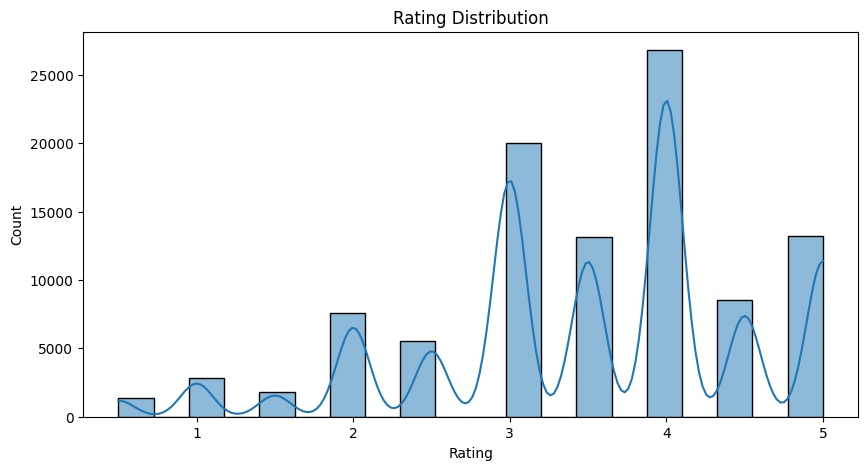

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(ratings['rating'], bins=20, kde=True)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


## Plot top genres (bar chart)

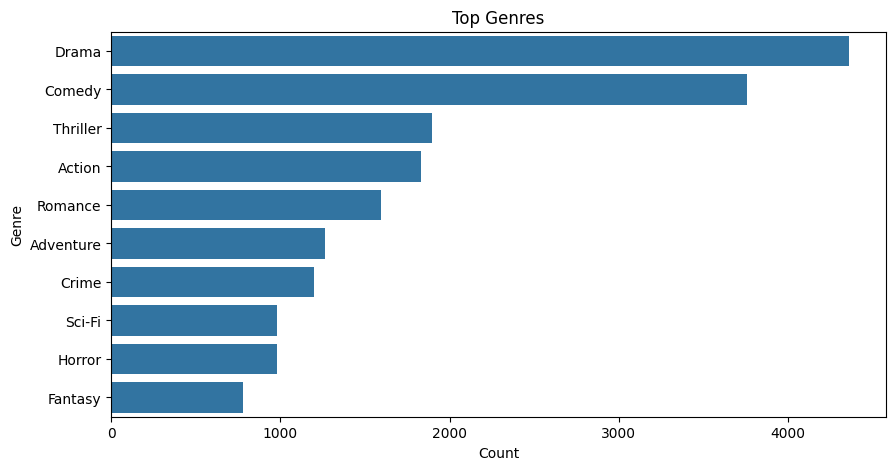

In [99]:
movies_genres = movies.assign(genre=movies['genres'].str.split('|')).explode('genre')

top_genres = movies_genres['genre'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_genres.values, y=top_genres.index)
plt.title("Top Genres")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()


## Matrix Factorization Based Movie Recommendation Model (SVD)

In [100]:

reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2)

model = SVD()
model.fit(trainset)

predictions = model.test(testset)
accuracy.rmse(predictions)
# Load Model in pkl file
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

RMSE: 0.8709


In [91]:
model.predict(37,10)


Prediction(uid=37, iid=10, r_ui=None, est=3.755365768369473, details={'was_impossible': False})

In [92]:
user_id = 37
rated_movies = ratings[ratings['userId'] == user_id]['movieId']

all_movies = movies['movieId']
unrated_movies = all_movies[~all_movies.isin(rated_movies)]

predictions = []

for movie_id in unrated_movies:
    pred = model.predict(user_id, movie_id)
    predictions.append((movie_id, pred.est))
predictions.sort(key=lambda x: x[1], reverse=True)

top_10 = predictions[:10]
top_10


[(750, 5.0),
 (1204, 4.977160336647585),
 (48516, 4.959278279455566),
 (2324, 4.931098047660206),
 (904, 4.900067134988576),
 (1208, 4.89464009833645),
 (2858, 4.847141502023589),
 (1246, 4.828309510129606),
 (912, 4.819046527386451),
 (923, 4.818002339997166)]

In [93]:
recommended_movies = movies[movies['movieId'].isin([x[0] for x in top_10])]
recommended_movies[['title', 'genres']]


,title,genres
602,dr. strangelove or: how i learned to stop worr...,Comedy|War
686,rear window,Mystery|Thriller
694,casablanca,Drama|Romance
705,citizen kane,Drama|Mystery
906,lawrence of arabia,Adventure|Drama|War
909,apocalypse now,Action|Drama|War
945,dead poets society,Drama
1730,life is beautiful (la vita è bella),Comedy|Drama|Romance|War
2145,american beauty,Drama|Romance
6315,"departed, the",Crime|Drama|Thriller
